#  Import Libraries

In [1]:
# Import all the libraries that we shall be using
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score, precision_score, auc, roc_auc_score, roc_curve
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier


import xgboost as xgb

# Import Data and Preprocessing

#### PC3 Data

In [2]:
# Install PC3 cancer cell line gene expression
PC3 = pd.read_csv('/Users/ravinschmidl/Desktop/Systems_Bio/ML_and_MV_Stats/Assignment/Code/p8-pc3-camda2020.csv')
PC3 = PC3.sort_values(['CAM_ID'], axis = 0)

#### MCF7 Data

In [3]:
# Install MCF7 cancer cell line gene expression

MCF7 = pd.read_csv('/Users/ravinschmidl/Desktop/Systems_Bio/ML_and_MV_Stats/Assignment/Code/p7-mcf7-camda2020.csv')
MCF7 = MCF7.sort_values(['CAM_ID'], axis = 0)

#### Combine Expression profiles

In [4]:
gene_expression = pd.merge(MCF7, PC3, on = 'CAM_ID', suffixes=('_pc3', '_mcf7'))
key = gene_expression['CAM_ID']


#### TargetLabels

In [5]:
# Install DILI targets; These are the labels for the training and set set.  
    # Only keep binary DILI targets and average score of targets. 
Targets = pd.read_csv('/Users/ravinschmidl/Desktop/Systems_Bio/ML_and_MV_Stats/Assignment/Code/targets-camda2020.csv')
targets = Targets.drop(['DILI2', 'DILI4', 'Training_Validation'], axis = 1)

#Based on research it was hard to identify targets, so instead we're trying to predict which drugs cause the most damage. 
# Identifying drugs that cause more thsn one DILI is crucial. 

In [6]:
#Identifying the label train and test vector
    #Training set contains labells and Test set contains NA values because it is empty.
ytrain = targets[:422]
ytest = targets[422:]

In [7]:
#Initialise feature (x) and label (y) training and set sets. 
xtrain = pd.merge(ytrain['CAM_ID'], gene_expression, on = 'CAM_ID')
xtest = pd.merge(ytest['CAM_ID'], gene_expression, on = 'CAM_ID')
ytrain = pd.merge(gene_expression['CAM_ID'], ytrain, on = 'CAM_ID')
ytest = pd.merge(gene_expression['CAM_ID'], ytest, on = 'CAM_ID')


In [8]:
print(ytrain.shape, xtrain.shape, ytest.shape, xtest.shape)

(415, 5) (415, 24657) (194, 5) (194, 24657)


In [12]:
xtrain = xtrain.set_index('CAM_ID')

,5720_pc3,466_pc3,6009_pc3,2309_pc3,387_pc3,3553_pc3,427_pc3,5898_pc3,23365_pc3,6657_pc3,...,2931_mcf7,63876_mcf7,51275_mcf7,158747_mcf7,283232_mcf7,25960_mcf7,6376_mcf7,11033_mcf7,54869_mcf7,60_mcf7
CAM_ID,,,,,,,,,,,,,,,,,,,,,
CAM00001,-0.913203,-0.083367,0.261545,-0.461476,0.547454,-0.190959,0.233886,0.130167,0.780081,0.035061,...,1.050850,1.011150,-1.011550,-0.467450,0.840700,0.541850,0.318850,0.990650,-1.102500,-0.543350
CAM00003,0.383504,-0.439723,0.583889,0.820379,-0.157482,-0.363386,-0.468173,0.059946,-0.294366,-0.455792,...,0.070700,0.282267,-0.315433,-0.078867,0.542767,1.313300,0.142667,-0.219100,0.220600,-0.219533
CAM00005,-1.486344,-0.368151,-0.271390,0.061859,0.071241,1.530317,1.363288,-0.307079,0.476123,0.744559,...,0.972571,-1.353085,-1.010963,-1.001739,-0.582926,-0.157845,-0.245675,-1.326316,-0.175902,0.491094
CAM00006,-1.569639,-1.363195,0.772321,-0.914671,0.812538,1.860777,-0.372448,0.134384,0.385260,1.378450,...,-1.540890,-0.274313,-0.558185,-0.097727,-0.397620,-0.296637,0.236686,0.135861,-0.167555,-0.506497
CAM00007,0.716991,1.038144,0.515456,-0.884920,0.151379,-0.132103,1.192100,-0.036297,-0.262100,0.111767,...,2.221181,1.383186,0.913973,1.998311,1.563978,1.475386,-1.000150,1.939200,3.788171,-1.412471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAM00613,0.120961,0.420255,1.271838,-0.334906,-0.576179,0.444015,1.073678,0.185873,-0.066294,0.060745,...,0.356000,-0.426950,0.203950,-0.029700,1.044300,-0.520800,0.518800,-0.266700,-0.617450,-0.375600
CAM00614,-0.027434,0.152992,0.212781,-0.260456,-0.234111,0.033223,0.635852,-0.031444,-0.027726,2.291716,...,-0.910864,0.412985,0.568428,-0.412997,0.716142,0.104383,0.901970,-0.309900,0.105838,-1.429622
CAM00615,-2.393950,-2.417200,2.185700,1.984000,-1.975150,0.185650,0.215850,2.238400,-1.568850,2.216550,...,0.222164,0.463683,-0.405028,0.124917,-0.215392,0.980206,0.723033,2.021044,0.908080,0.056689


In [10]:
xtrain.describe()

,5720_pc3,466_pc3,6009_pc3,2309_pc3,387_pc3,3553_pc3,427_pc3,5898_pc3,23365_pc3,6657_pc3,...,2931_mcf7,63876_mcf7,51275_mcf7,158747_mcf7,283232_mcf7,25960_mcf7,6376_mcf7,11033_mcf7,54869_mcf7,60_mcf7
count,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,...,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000
mean,-0.113320,-0.182748,-0.030984,0.023114,0.037693,0.250458,0.067036,-0.229218,0.035884,0.283974,...,0.163113,0.035888,-0.058599,0.013876,0.073182,0.056430,-0.006443,0.066566,0.087436,-0.030709
std,0.990700,0.989421,0.822131,1.056915,0.885491,0.878747,0.879400,1.006693,0.813351,0.862939,...,0.881503,0.726181,0.846846,0.809555,0.882673,0.716632,0.685612,0.761367,0.831843,0.756054
min,-6.509868,-5.695687,-3.897148,-5.829300,-4.648761,-1.659244,-3.206841,-4.586658,-3.660804,-1.421000,...,-1.808111,-1.716400,-5.346248,-2.062603,-2.283488,-2.423150,-2.272900,-2.018950,-1.825375,-5.065700
25%,-0.524478,-0.627195,-0.515001,-0.530548,-0.425321,-0.312661,-0.493380,-0.642675,-0.431470,-0.317209,...,-0.409048,-0.453285,-0.496591,-0.499709,-0.443430,-0.481893,-0.466332,-0.435060,-0.434950,-0.421289
50%,0.018551,-0.055550,-0.052813,-0.023762,-0.003917,0.122495,0.040879,-0.059717,0.054088,0.162741,...,0.103641,-0.023450,-0.043450,-0.054409,-0.060039,0.054100,-0.006650,0.029945,0.044650,0.012347
75%,0.412945,0.490797,0.397191,0.551154,0.433120,0.688565,0.574630,0.306941,0.426220,0.758740,...,0.595452,0.464264,0.463180,0.436502,0.484786,0.489863,0.454166,0.446686,0.542795,0.442044
max,2.876085,2.208701,3.455700,4.420281,4.471329,5.371536,3.859636,4.388584,4.901399,5.547956,...,5.224118,2.547363,2.966700,3.385280,5.791200,3.323357,2.222550,2.935350,3.788171,2.034174


In [13]:
xtest = xtest.set_index('CAM_ID')
X_train = xtrain.T
X_test = xtest.T

In [14]:
## Save these for later
Final_Train = X_train
Final_Test = X_test

In [15]:
print(ytrain.shape, X_train.shape, ytest.shape, X_test.shape)

(415, 5) (24656, 415) (194, 5) (24656, 194)


In [ ]:
X_test

In [16]:
#As train and test sets can only have numeric data and using string/char in index is hard;
    # set a train and test key to identify drugs.
    # each column is a drug in the train and each row is a drug in the test. 
ytrain = ytrain.set_index('CAM_ID')
ytest = ytest.set_index('CAM_ID')


In [17]:
X_train = X_train.astype(float, 64)
X_test = X_test.astype(float, 64)

In [18]:
# Apply the same scaling to both datasets
scaler = StandardScaler()
X_train_scld = scaler.fit_transform(X_train)
X_test_scld = scaler.fit_transform(X_test) 

## PCA

In [19]:
pca = PCA()
pca.fit_transform(X_train)

array([[-1.29320899e+01, -3.64678276e-01, -3.02691625e+00, ...,
        -2.19733496e-02, -3.22720495e-02,  3.90019315e-01],
       [-1.29421595e+01, -4.80993799e+00,  3.85604471e+00, ...,
        -1.31914497e-02,  1.40006389e-01,  1.06568586e-01],
       [-3.76219074e+00,  9.19883134e-01,  1.28215805e+00, ...,
         2.20436100e-01,  2.41710972e-01, -2.24636145e-01],
       ...,
       [ 3.79073539e+00, -4.71078379e+00, -7.86692568e-01, ...,
        -3.23717016e-01,  2.22517629e-01,  2.23506980e-02],
       [ 3.33807630e+00, -6.57334556e+00, -3.78954860e+00, ...,
        -4.28905328e-02, -1.45091425e-01, -1.75536324e-02],
       [-7.48675260e+00,  4.01244433e+00, -4.25699461e+00, ...,
         2.60601693e-01,  5.46021895e-03, -8.75741014e-02]])

Number of features that explain ~90% variance:  127


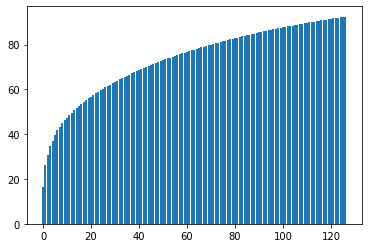

In [21]:
total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1
    
print("Number of features that explain ~90% variance: ", k)
pca = PCA(n_components=k)
X_train.pca = pca.fit(X_train)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp);

[]

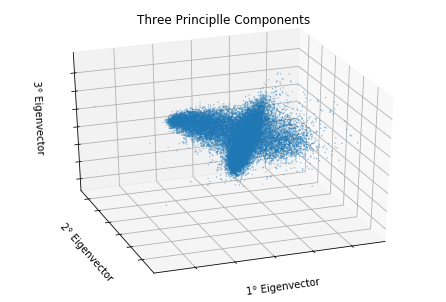

In [22]:
pca3 = PCA(n_components=3).fit(X_train)
X_train_PCA = pca3.fit_transform(X_train)

plt.clf()
fig = plt.figure(1, figsize=(10,6 ))
ax = Axes3D(fig, elev=-150, azim=110,)
ax.scatter(X_train_PCA[:, 0], X_train_PCA[:, 1], X_train_PCA[:, 2], s = 0.1)
ax.set_title("Three Principlle Components")
ax.set_xlabel("1° Eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2° Eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3° Eigenvector")
ax.w_zaxis.set_ticklabels([])

Text(0.5, 1.0, '2D Transformation of the Above Graph')

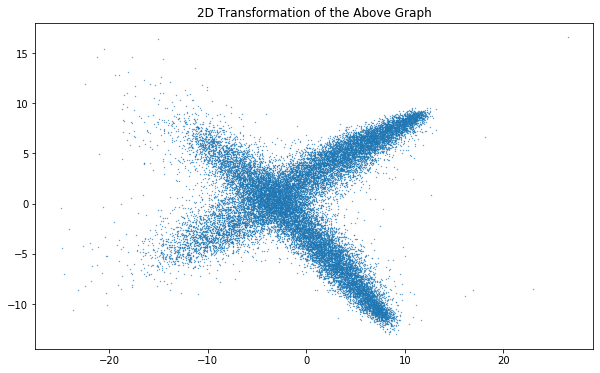

In [23]:
fig = plt.figure(1, figsize = (10, 6))
plt.scatter(X_train_PCA[:, 0],  X_train_PCA[:, 1], s = 0.1)
plt.title("2D Transformation of the Above Graph")

# Plots

## ROC

In [139]:
def plotROC(fpr, tpr, roc_auc):   
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

## Confusion Matrix Heatmap

In [25]:
#Confusion Matrix
def cM(y_test, pred):
    cm = confusion_matrix(y_test, pred)

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Greens') 

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('K-means Confusion Matrix') 
    ax.xaxis.set_ticklabels(['No DILI', 'DILI']) 
    ax.yaxis.set_ticklabels(['No DILI', 'DILI'], rotation=360)

### Building and Validation with Training Set only

In [29]:
#We want to see how accurate our models are; so we will do this with our training data. 
    #Split X_train and y_train into and 80/20 train/test split to test accuracy
    
A_train, A_test, B_train, B_test= train_test_split(X_train.T, ytrain, test_size = 0.2, random_state = 42)

In [30]:
print(B_train.shape, A_train.shape, B_test.shape, A_test.shape)
print(ytrain.shape, X_train.shape, ytest.shape, X_test.shape)


(332, 4) (332, 24656) (83, 4) (83, 24656)
(415, 4) (24656, 415) (194, 4) (24656, 194)


#### K-Nearest Neighbours


In [31]:
def kNN(X_train, X_test, y_train) :
    neighbours = KNeighborsClassifier(n_neighbors=5)

    neighbours.fit(X_train,y_train)

    predictions = neighbours.predict(X_test)
    y_prob = neighbours.predict_proba(X_test)

    return(predictions, y_prob)

In [32]:
p_kNN_DILI1, y_kNN_DILI1 = kNN(A_train, A_test, B_train['DILI1'])
p_kNN_DILI3, y_kNN_DILI3 = kNN(A_train, A_test, B_train['DILI3'])
p_kNN_DILI5, y_kNN_DILI5 = kNN(A_train, A_test, B_train['DILI5'])
p_kNN_DILI6, y_kNN_DILI6 = kNN(A_train, A_test, B_train['DILI6'])

In [33]:
#Calculate Accuracy
print('K-means accuracy (DILI1): ', round(accuracy_score(B_test.iloc[:,0], p_kNN_DILI1), 3))
print('K-means accuracy (DILI3): ', round(accuracy_score(B_test.iloc[:,1], p_kNN_DILI3), 3))
print('K-means accuracy (DILI5): ', round(accuracy_score(B_test.iloc[:,2], p_kNN_DILI5), 3))
print('K-means accuracy (DILI6): ', round(accuracy_score(B_test.iloc[:,3], p_kNN_DILI6), 3))

K-means accuracy (DILI1):  0.735
K-means accuracy (DILI3):  0.434
K-means accuracy (DILI5):  0.506
K-means accuracy (DILI6):  0.614


In [34]:
#Calculate Balanced Accuracy
print('K-means balanced accuracy (DILI1): ', round(balanced_accuracy_score(B_test.iloc[:,0], p_kNN_DILI1), 3))
print('K-means balanced accuracy (DILI3): ', round(balanced_accuracy_score(B_test.iloc[:,1], p_kNN_DILI3), 3))
print('K-means balanced accuracy (DILI5): ', round(balanced_accuracy_score(B_test.iloc[:,2], p_kNN_DILI5), 3))
print('K-means balanced accuracy (DILI6): ', round(balanced_accuracy_score(B_test.iloc[:,3], p_kNN_DILI6), 3))

K-means balanced accuracy (DILI1):  0.508
K-means balanced accuracy (DILI3):  0.424
K-means balanced accuracy (DILI5):  0.51
K-means balanced accuracy (DILI6):  0.608


In [35]:
#Calculate Precision Score
print('KNN Precision (DILI1): ', round(precision_score(B_test.iloc[:,0], p_kNN_DILI1), 3))
print('KNN Precision (DILI3): ', round(precision_score(B_test.iloc[:,1], p_kNN_DILI3), 3))
print('KNN Precision (DILI5): ', round(precision_score(B_test.iloc[:,2], p_kNN_DILI5), 3))
print('KNN Precision (DILI6): ', round(precision_score(B_test.iloc[:,3], p_kNN_DILI6), 3))


KNN Precision (DILI1):  0.333
KNN Precision (DILI3):  0.3
KNN Precision (DILI5):  0.49
KNN Precision (DILI6):  0.588


In [158]:
#Calculate Precision Score
print('KNN ROC AUC Score (DILI1): ', round(roc_auc_score(B_test.iloc[:,0], y_kNN_DILI1[:,0]), 3))
print('KNN ROC AUC Score (DILI3): ', round(roc_auc_score(B_test.iloc[:,1], y_kNN_DILI3[:,0]), 3))
print('KNN ROC AUC Score (DILI5): ', round(roc_auc_score(B_test.iloc[:,2], y_kNN_DILI5[:,0]), 3))
print('KNN ROC AUC Score (DILI6): ', round(roc_auc_score(B_test.iloc[:,3], y_kNN_DILI6[:,0]), 3))

KNN ROC AUC Score (DILI1):  0.434
KNN ROC AUC Score (DILI3):  0.597
KNN ROC AUC Score (DILI5):  0.515
KNN ROC AUC Score (DILI6):  0.373


In [43]:
fpr_KNN_DILI1, tpr_KNN_DILI1, _ = roc_curve(B_test.iloc[:,0], y_kNN_DILI1[:,0])
fpr_KNN_DILI3, tpr_KNN_DILI3, _ = roc_curve(B_test.iloc[:,0], y_kNN_DILI3[:,0])
fpr_KNN_DILI5, tpr_KNN_DILI5, _ = roc_curve(B_test.iloc[:,0], y_kNN_DILI5[:,0])
fpr_KNN_DILI6, tpr_KNN_DILI6, _ = roc_curve(B_test.iloc[:,0], y_kNN_DILI6[:,0])

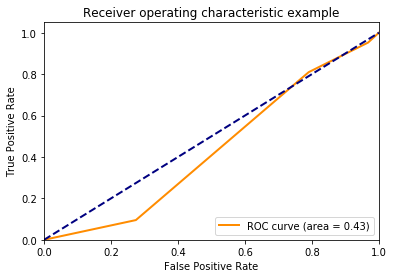

In [159]:
plotROC(fpr_KNN_DILI1, tpr_KNN_DILI1, roc_auc_score(B_test.iloc[:,0], y_kNN_DILI1[:,0]))

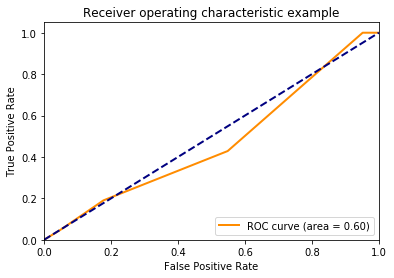

In [160]:
plotROC(fpr_KNN_DILI3, tpr_KNN_DILI3, roc_auc_score(B_test.iloc[:,1], y_kNN_DILI3[:,0]))

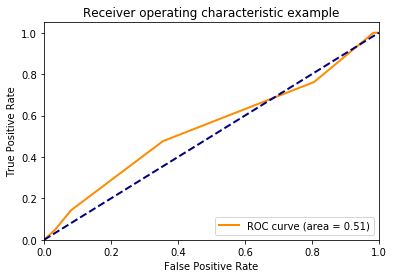

In [161]:
plotROC(fpr_KNN_DILI5, tpr_KNN_DILI5, roc_auc_score(B_test.iloc[:,2], y_kNN_DILI5[:,0]))

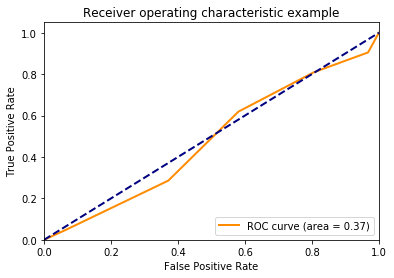

In [162]:
plotROC(fpr_KNN_DILI6, tpr_KNN_DILI6, roc_auc_score(B_test.iloc[:,3], y_kNN_DILI6[:,0]))

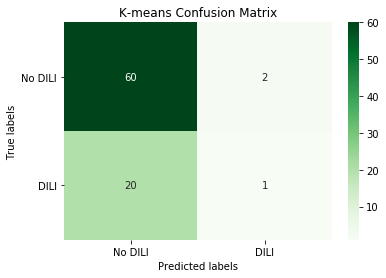

In [49]:
cM(B_test.iloc[:,0], p_kNN_DILI1)

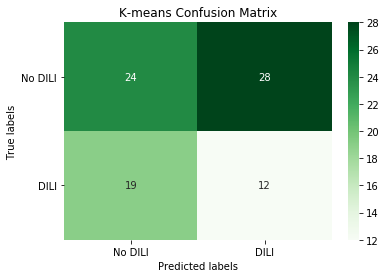

In [53]:
cM(B_test.iloc[:,1], p_kNN_DILI3)

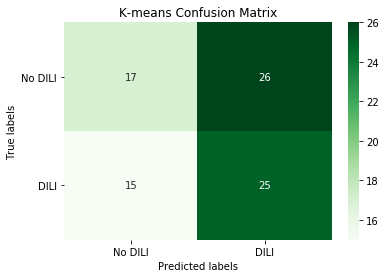

In [54]:
cM(B_test.iloc[:,2], p_kNN_DILI5)

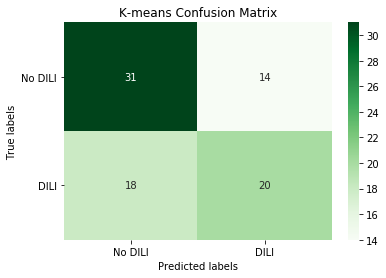

In [55]:
cM(B_test.iloc[:,3], p_kNN_DILI6)

#### Naive Bayes

In [56]:
def nB(X_train, X_test, y_train):
    gauss = GaussianNB()

    ## Place the training data in the MLP to train your algorithm
    gauss.fit(X_train,y_train)

    ## This is where we test the trained algorithm
    predictions = gauss.predict(X_test)
    y_prob = gauss.predict_proba(X_test)

    return predictions, y_prob

In [57]:
p_nB_DILI1, y_nB_DILI1 = nB(A_train, A_test, B_train['DILI1'])
p_nB_DILI3, y_nB_DILI3 = nB(A_train, A_test, B_train['DILI3'])
p_nB_DILI5, y_nB_DILI5 = nB(A_train, A_test, B_train['DILI5'])
p_nB_DILI6, y_nB_DILI6 = nB(A_train, A_test, B_train['DILI6'])

In [58]:
#Calculate Accuracy
print('Naive Bayes accuracy (DILI1): ', round(accuracy_score(B_test.iloc[:,0], p_nB_DILI1), 3))
print('Naive Bayes accuracy (DILI3): ', round(accuracy_score(B_test.iloc[:,1], p_nB_DILI3), 3))
print('Naive Bayes accuracy (DILI5): ', round(accuracy_score(B_test.iloc[:,2], p_nB_DILI5), 3))
print('Naive Bayes accuracy (DILI6): ', round(accuracy_score(B_test.iloc[:,3], p_nB_DILI6), 3))

Naive Bayes accuracy (DILI1):  0.47
Naive Bayes accuracy (DILI3):  0.554
Naive Bayes accuracy (DILI5):  0.47
Naive Bayes accuracy (DILI6):  0.602


In [59]:
#Calculate Balanced Accuracy
print('Naive balanced Bayes accuracy (DILI1): ', round(balanced_accuracy_score(B_test.iloc[:,0], p_nB_DILI1), 3))
print('Naive balanced Bayes accuracy (DILI3): ', round(balanced_accuracy_score(B_test.iloc[:,1], p_nB_DILI3), 3))
print('Naive balanced Bayes accuracy (DILI5): ', round(balanced_accuracy_score(B_test.iloc[:,2], p_nB_DILI5), 3))
print('Naive balanced Bayes accuracy (DILI6): ', round(balanced_accuracy_score(B_test.iloc[:,3], p_nB_DILI6), 3))

Naive balanced Bayes accuracy (DILI1):  0.551
Naive balanced Bayes accuracy (DILI3):  0.52
Naive balanced Bayes accuracy (DILI5):  0.466
Naive balanced Bayes accuracy (DILI6):  0.59


In [60]:
#Calculate Precision Score
print('NB Precision (DILI1): ', round(precision_score(B_test.iloc[:,0], p_nB_DILI1), 3))
print('NB Precision  (DILI3): ', round(precision_score(B_test.iloc[:,1], p_nB_DILI3), 3))
print('NB Precision  (DILI5): ', round(precision_score(B_test.iloc[:,2], p_nB_DILI5), 3))
print('NB Precision  (DILI6): ', round(precision_score(B_test.iloc[:,3], p_nB_DILI6), 3))


NB Precision (DILI1):  0.283
NB Precision  (DILI3):  0.4
NB Precision  (DILI5):  0.438
NB Precision  (DILI6):  0.586


In [61]:
#Calculate Precision Score
print('NB ROC AUC Score (DILI1): ', round(roc_auc_score(B_test.iloc[:,0], y_nB_DILI1[:,0]), 3))
print('NB ROC AUC Score (DILI3): ', round(roc_auc_score(B_test.iloc[:,1], y_nB_DILI3[:,0]), 3))
print('NB ROC AUC Score (DILI5): ', round(roc_auc_score(B_test.iloc[:,2], y_nB_DILI5[:,0]), 3))
print('NB ROC AUC Score (DILI6): ', round(roc_auc_score(B_test.iloc[:,3], y_nB_DILI6[:,0]), 3))


NB ROC AUC Score (DILI1):  0.464
NB ROC AUC Score (DILI3):  0.473
NB ROC AUC Score (DILI5):  0.535
NB ROC AUC Score (DILI6):  0.39


In [90]:
fpr_NB_DILI1, tpr_NB_DILI1, _ = roc_curve(B_test.iloc[:,0], y_nB_DILI1[:,0])
fpr_NB_DILI3, tpr_NB_DILI3, _ = roc_curve(B_test.iloc[:,0], y_nB_DILI3[:,0])
fpr_NB_DILI5, tpr_NB_DILI5, _ = roc_curve(B_test.iloc[:,0], y_nB_DILI5[:,0])
fpr_NB_DILI6, tpr_NB_DILI6, _ = roc_curve(B_test.iloc[:,0], y_nB_DILI6[:,0])

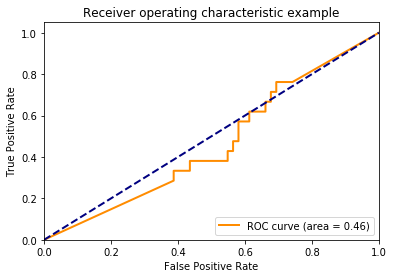

In [163]:
plotROC(fpr_NB_DILI1, tpr_NB_DILI1, roc_auc_score(B_test.iloc[:,0], y_nB_DILI1[:,0]))

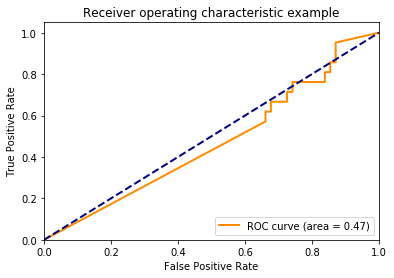

In [164]:
plotROC(fpr_NB_DILI3, tpr_NB_DILI3, roc_auc_score(B_test.iloc[:,1], y_nB_DILI3[:,0]))

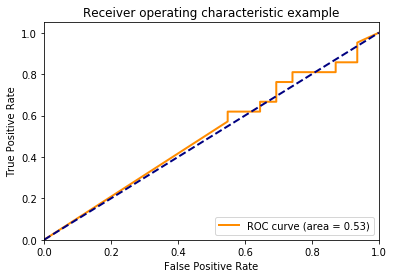

In [165]:
plotROC(fpr_NB_DILI5, tpr_NB_DILI5, roc_auc_score(B_test.iloc[:,2], y_nB_DILI5[:,0]))

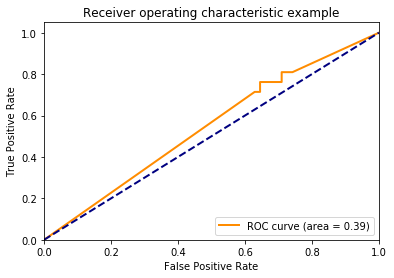

In [166]:
plotROC(fpr_NB_DILI6, tpr_NB_DILI6, roc_auc_score(B_test.iloc[:,3], y_nB_DILI6[:,0]))

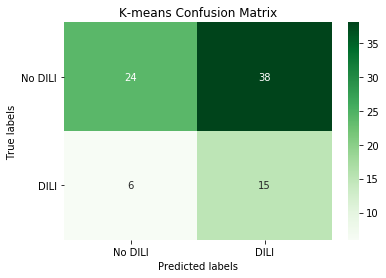

In [63]:
cM(B_test.iloc[:,0], p_nB_DILI1)

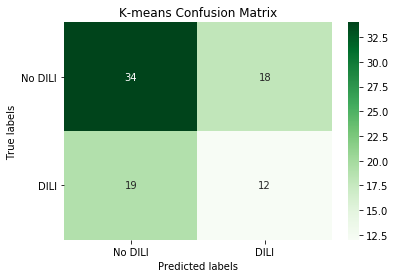

In [64]:
cM(B_test.iloc[:,1], p_nB_DILI3)

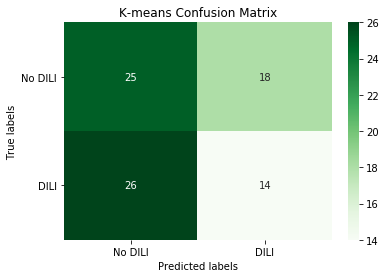

In [65]:
cM(B_test.iloc[:,2], p_nB_DILI5)

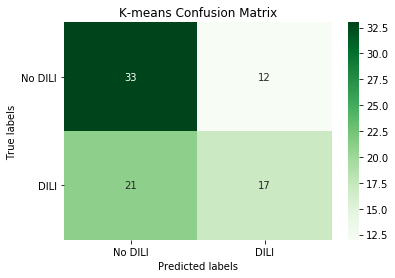

In [66]:
cM(B_test.iloc[:,3], p_nB_DILI6)

#### Linear Regression

In [67]:
def lR(X_train, X_test, y_train) :
    classifier = linear_model.LogisticRegression()

    ## Place the training data in the MLP to train your algorithm
    classifier.fit(X_train,y_train)
    ## This is where we test the trained algorithm
    predictions = classifier.predict(X_test)
    y_prob = classifier.predict_proba(X_test)

    return predictions, y_prob

In [68]:
p_lR_DILI1, y_lR_DILI1 = lR(A_train, A_test, B_train['DILI1'])
p_lR_DILI3, y_lR_DILI3 = lR(A_train, A_test, B_train['DILI3'])
p_lR_DILI5, y_lR_DILI5 = lR(A_train, A_test, B_train['DILI5'])
p_lR_DILI6, y_lR_DILI6 = lR(A_train, A_test, B_train['DILI6'])

/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [69]:
#Calculate Accuracy
print('Linear Regression accuracy (DILI1): ', round(accuracy_score(B_test.iloc[:,0], p_lR_DILI1), 3))
print('Linear Regression accuracy (DILI3): ', round(accuracy_score(B_test.iloc[:,1], p_lR_DILI3), 3))
print('Linear Regression accuracy (DILI5): ', round(accuracy_score(B_test.iloc[:,2], p_lR_DILI5), 3))
print('Linear Regression accuracy (DILI6): ', round(accuracy_score(B_test.iloc[:,3], p_lR_DILI6), 3))

Linear Regression accuracy (DILI1):  0.687
Linear Regression accuracy (DILI3):  0.53
Linear Regression accuracy (DILI5):  0.373
Linear Regression accuracy (DILI6):  0.639


In [70]:
#Calculate Balanced Accuracy
print('Linear Regression balanced accuracy (DILI1): ', round(balanced_accuracy_score(B_test.iloc[:,0], p_lR_DILI1), 3))
print('Linear Regression balanced accuracy (DILI3): ', round(balanced_accuracy_score(B_test.iloc[:,1], p_lR_DILI3), 3))
print('Linear Regression balanced accuracy (DILI5): ', round(balanced_accuracy_score(B_test.iloc[:,2], p_lR_DILI5), 3))
print('Linear Regression balanced accuracy (DILI6): ', round(balanced_accuracy_score(B_test.iloc[:,3], p_lR_DILI6), 3))

Linear Regression balanced accuracy (DILI1):  0.523
Linear Regression balanced accuracy (DILI3):  0.508
Linear Regression balanced accuracy (DILI5):  0.372
Linear Regression balanced accuracy (DILI6):  0.642


In [71]:
#Calculate Precision Score
print('LR Precision (DILI1): ', round(precision_score(B_test.iloc[:,0], p_lR_DILI1), 3))
print('LR Precision  (DILI3): ', round(precision_score(B_test.iloc[:,1], p_lR_DILI3), 3))
print('LR Precision  (DILI5): ', round(precision_score(B_test.iloc[:,2], p_lR_DILI5), 3))
print('LR Precision  (DILI6): ', round(precision_score(B_test.iloc[:,3], p_lR_DILI6), 3))


LR Precision (DILI1):  0.308
LR Precision  (DILI3):  0.382
LR Precision  (DILI5):  0.342
LR Precision  (DILI6):  0.591


In [72]:
#Calculate ROC AUC Score
print('LR ROC AUC Score (DILI1): ', round(roc_auc_score(B_test.iloc[:,0], y_lR_DILI1[:,0]), 3))
print('LR ROC AUC Score (DILI3): ', round(roc_auc_score(B_test.iloc[:,1], y_lR_DILI3[:,0]), 3))
print('LR ROC AUC Score (DILI5): ', round(roc_auc_score(B_test.iloc[:,2], y_lR_DILI5[:,0]), 3))
print('LR ROC AUC Score (DILI6): ', round(roc_auc_score(B_test.iloc[:,3], y_lR_DILI6[:,0]), 3))


LR ROC AUC Score (DILI1):  0.581
LR ROC AUC Score (DILI3):  0.493
LR ROC AUC Score (DILI5):  0.629
LR ROC AUC Score (DILI6):  0.334


In [95]:
fpr_LR_DILI1, tpr_LR_DILI1, _ = roc_curve(B_test.iloc[:,0], y_lR_DILI1[:,0])
fpr_LR_DILI3, tpr_LR_DILI3, _ = roc_curve(B_test.iloc[:,0], y_lR_DILI3[:,0])
fpr_LR_DILI5, tpr_LR_DILI5, _ = roc_curve(B_test.iloc[:,0], y_lR_DILI5[:,0])
fpr_LR_DILI6, tpr_LR_DILI6, _ = roc_curve(B_test.iloc[:,0], y_lR_DILI6[:,0])


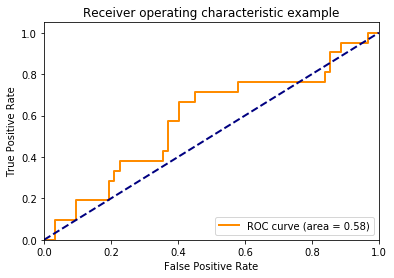

In [167]:
plotROC(fpr_LR_DILI1, tpr_LR_DILI1, roc_auc_score(B_test.iloc[:,0], y_lR_DILI1[:,0]))

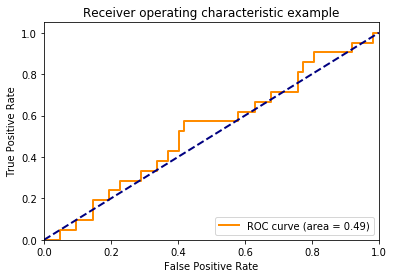

In [168]:
plotROC(fpr_LR_DILI3, tpr_LR_DILI3, roc_auc_score(B_test.iloc[:,1], y_lR_DILI3[:,0]))

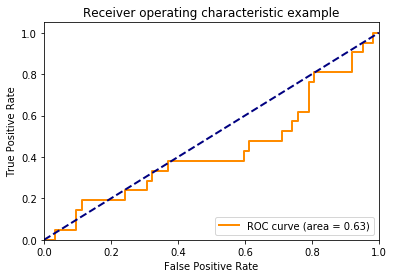

In [169]:
plotROC(fpr_LR_DILI5, tpr_LR_DILI5, roc_auc_score(B_test.iloc[:,2], y_lR_DILI5[:,0]))

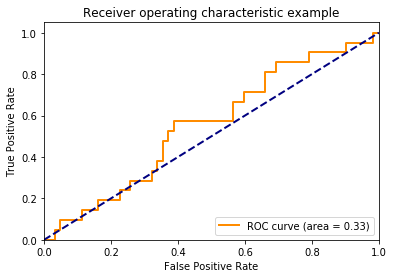

In [170]:
plotROC(fpr_LR_DILI6, tpr_LR_DILI6, roc_auc_score(B_test.iloc[:,3], y_lR_DILI6[:,0]))

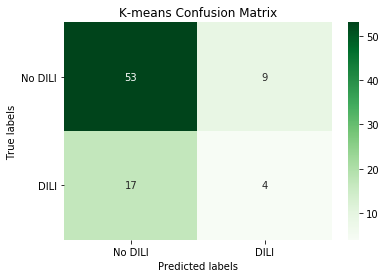

In [73]:
cM(B_test.iloc[:,0], p_lR_DILI1)

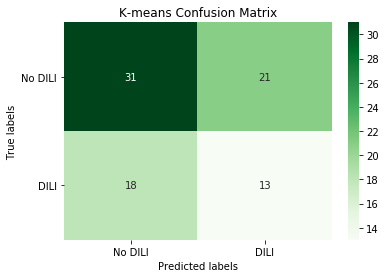

In [74]:
cM(B_test.iloc[:,1], p_lR_DILI3)

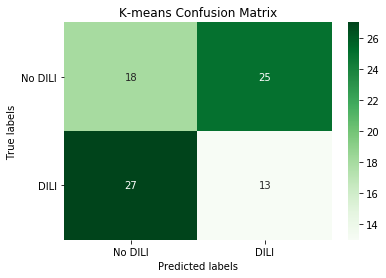

In [76]:
cM(B_test.iloc[:,2], p_lR_DILI5)

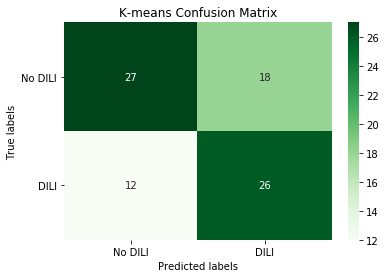

In [77]:
cM(B_test.iloc[:,3], p_lR_DILI6)

#### Random Forest

In [78]:
def rF(X_train, X_test, y_train) :

    ## Build your classifier
    RF = RandomForestClassifier(random_state=0)

    ## Place the training data in the MLP to train your algorithm
    RF.fit(X_train, y_train)

    ## This is where we test the trained algorithm
    predictions = RF.predict(X_test)
    y_prob = RF.predict_log_proba(X_test)

    return predictions, y_prob

In [79]:
p_rF_DILI1, y_rF_DILI1 = rF(A_train, A_test, B_train['DILI1'])
p_rF_DILI3, y_rF_DILI3 = rF(A_train, A_test, B_train['DILI3'])
p_rF_DILI5, y_rF_DILI5 = rF(A_train, A_test, B_train['DILI5'])
p_rF_DILI6, y_rF_DILI6 = rF(A_train, A_test, B_train['DILI6'])

/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:630: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:630: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 

In [80]:
#Calculate Accuracy
print('Random Forest accuracy (DILI1): ', round(accuracy_score(B_test.iloc[:,0], p_rF_DILI1), 3))
print('Random Forest accuracy (DILI3): ', round(accuracy_score(B_test.iloc[:,1], p_rF_DILI3), 3))
print('Random Forest accuracy (DILI5): ', round(accuracy_score(B_test.iloc[:,2], p_rF_DILI5), 3))
print('Random Forest accuracy (DILI6): ', round(accuracy_score(B_test.iloc[:,3], p_rF_DILI6), 3))

Random Forest accuracy (DILI1):  0.735
Random Forest accuracy (DILI3):  0.59
Random Forest accuracy (DILI5):  0.554
Random Forest accuracy (DILI6):  0.59


In [81]:
#Calculate Balanced Accuracy
print('Random Forest balanced accuracy (DILI1): ', round(balanced_accuracy_score(B_test.iloc[:,0], p_rF_DILI1), 3))
print('Random Forest balanced accuracy (DILI3): ', round(balanced_accuracy_score(B_test.iloc[:,1], p_rF_DILI3), 3))
print('Random Forest balanced accuracy (DILI5): ', round(balanced_accuracy_score(B_test.iloc[:,2], p_rF_DILI5), 3))
print('Random Forest balanced accuracy (DILI6): ', round(balanced_accuracy_score(B_test.iloc[:,3], p_rF_DILI6), 3))

Random Forest balanced accuracy (DILI1):  0.523
Random Forest balanced accuracy (DILI3):  0.53
Random Forest balanced accuracy (DILI5):  0.551
Random Forest balanced accuracy (DILI6):  0.587


In [82]:
#Calculate Precision Score
print('RF Precision (DILI1): ', round(precision_score(B_test.iloc[:,0], p_rF_DILI1), 3))
print('RF Precision  (DILI3): ', round(precision_score(B_test.iloc[:,1], p_rF_DILI3), 3))
print('RF Precision  (DILI5): ', round(precision_score(B_test.iloc[:,2], p_rF_DILI5), 3))
print('RF Precision  (DILI6): ', round(precision_score(B_test.iloc[:,3], p_rF_DILI6), 3))


RF Precision (DILI1):  0.4
RF Precision  (DILI3):  0.429
RF Precision  (DILI5):  0.543
RF Precision  (DILI6):  0.553


In [83]:
#Calculate ROC AUC Score
print('RF ROC AUC Score (DILI1): ', round(roc_auc_score(B_test.iloc[:,0], y_rF_DILI1[:,0]), 3))
print('RF ROC AUC Score (DILI3): ', round(roc_auc_score(B_test.iloc[:,1], y_rF_DILI3[:,0]), 3))
print('RF ROC AUC Score (DILI5): ', round(roc_auc_score(B_test.iloc[:,2], y_rF_DILI5[:,0]), 3))
print('RF ROC AUC Score (DILI6): ', round(roc_auc_score(B_test.iloc[:,3], y_rF_DILI6[:,0]), 3))


RF ROC AUC Score (DILI1):  0.449
RF ROC AUC Score (DILI3):  0.455
RF ROC AUC Score (DILI5):  0.457
RF ROC AUC Score (DILI6):  0.388


In [101]:
fpr_RF_DILI1, tpr_RF_DILI1, _ = roc_curve(B_test.iloc[:,0], y_rF_DILI1[:,0])
fpr_RF_DILI3, tpr_RF_DILI3, _ = roc_curve(B_test.iloc[:,0], y_rF_DILI3[:,0])
fpr_RF_DILI5, tpr_RF_DILI5, _ = roc_curve(B_test.iloc[:,0], y_rF_DILI5[:,0])
fpr_RF_DILI6, tpr_RF_DILI6, _ = roc_curve(B_test.iloc[:,0], y_rF_DILI6[:,0])


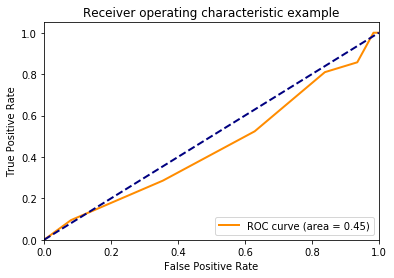

In [171]:
plotROC(fpr_RF_DILI1, tpr_RF_DILI1, roc_auc_score(B_test.iloc[:,0], y_rF_DILI1[:,0]))

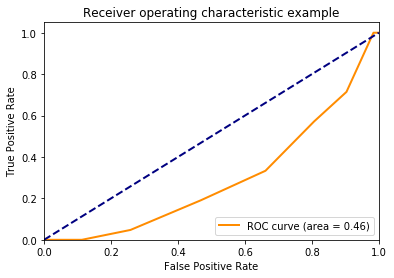

In [172]:
plotROC(fpr_RF_DILI3, tpr_RF_DILI3, roc_auc_score(B_test.iloc[:,1], y_rF_DILI3[:,0]))

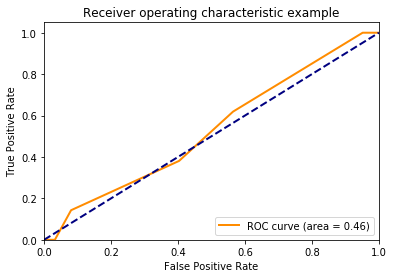

In [173]:
plotROC(fpr_RF_DILI5, tpr_RF_DILI5, roc_auc_score(B_test.iloc[:,2], y_rF_DILI5[:,0]))

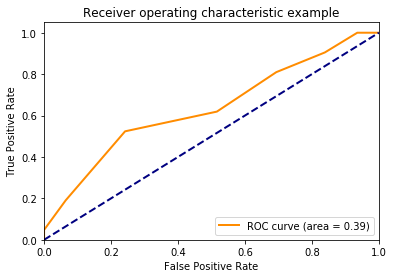

In [175]:
plotROC(fpr_RF_DILI6, tpr_RF_DILI6, roc_auc_score(B_test.iloc[:,3], y_rF_DILI6[:,0]))

In [ ]:
cM(B_test.iloc[:,0], p_rF_DILI1)

In [ ]:
cM(B_test.iloc[:,1], p_rF_DILI3)

In [ ]:
cM(B_test.iloc[:,2], p_rF_DILI5)

In [ ]:
cM(B_test.iloc[:,3], p_rF_DILI6)

#### Support Vector Machine

In [84]:
#Support Vector Machine
def sVM(X_train, X_test, y_train) :
    classifier = svm.SVC(probability = 1) #Set probability to 1 (TRUE) so that we can use predict_proba

    ## Place the training data in the MLP to train your algorithm
    classifier.fit(X_train,y_train)

    ## This is where we test the trained algorithm
    predictions = classifier.predict(X_test)

    y_prob = classifier.predict_proba(X_test)

    return(predictions, y_prob)

In [85]:
p_sVM_DILI1, y_sVM_DILI1 = sVM(A_train, A_test, B_train['DILI1'])
p_sVM_DILI3, y_sVM_DILI3 = sVM(A_train, A_test, B_train['DILI3'])
p_sVM_DILI5, y_sVM_DILI5 = sVM(A_train, A_test, B_train['DILI5'])
p_sVM_DILI6, y_sVM_DILI6 = sVM(A_train, A_test, B_train['DILI6'])

/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/ravinschmidl/anaconda3/lib/

In [86]:
#Calculate Accuracy
print('Support Vector Machine accuracy (DILI1): ', round(accuracy_score(B_test.iloc[:,0], p_sVM_DILI1), 3))
print('Support Vector Machine accuracy (DILI3): ', round(accuracy_score(B_test.iloc[:,1], p_sVM_DILI3), 3))
print('Support Vector Machine accuracy (DILI5): ', round(accuracy_score(B_test.iloc[:,2], p_sVM_DILI5), 3))
print('Support Vector Machine accuracy (DILI6): ', round(accuracy_score(B_test.iloc[:,3], p_sVM_DILI6), 3))

Support Vector Machine accuracy (DILI1):  0.747
Support Vector Machine accuracy (DILI3):  0.627
Support Vector Machine accuracy (DILI5):  0.458
Support Vector Machine accuracy (DILI6):  0.602


In [87]:
#Calculate Balanced Accuracy
print('Support Vector Machine balanced accuracy (DILI1): ', round(balanced_accuracy_score(B_test.iloc[:,0], p_sVM_DILI1), 3))
print('Support Vector Machine balanced accuracy (DILI3): ', round(balanced_accuracy_score(B_test.iloc[:,1], p_sVM_DILI3), 3))
print('Support Vector Machine balanced accuracy (DILI5): ', round(balanced_accuracy_score(B_test.iloc[:,2], p_sVM_DILI5), 3))
print('Support Vector Machine balanced accuracy (DILI6): ', round(balanced_accuracy_score(B_test.iloc[:,3], p_sVM_DILI6), 3))

Support Vector Machine balanced accuracy (DILI1):  0.5
Support Vector Machine balanced accuracy (DILI3):  0.5
Support Vector Machine balanced accuracy (DILI5):  0.45
Support Vector Machine balanced accuracy (DILI6):  0.611


In [88]:
#Calculate Precision Score
print('SVM precision (DILI1): ', round(precision_score(B_test.iloc[:,0], p_sVM_DILI1), 3))
print('SVM precision (DILI3): ', round(precision_score(B_test.iloc[:,1], p_sVM_DILI3), 3))
print('SVM precision (DILI5): ', round(precision_score(B_test.iloc[:,2], p_sVM_DILI5), 3))
print('SVM precision (DILI6): ', round(precision_score(B_test.iloc[:,3], p_sVM_DILI6), 3))


SVM precision (DILI1):  0.0
SVM precision (DILI3):  0.0
SVM precision (DILI5):  0.391
SVM precision (DILI6):  0.551


/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [89]:
#Calculate ROC AUC Score
print('SVM ROC AUC Score (DILI1): ', round(roc_auc_score(B_test.iloc[:,0], y_sVM_DILI1[:,0]), 3))
print('SVM ROC AUC Score (DILI3): ', round(roc_auc_score(B_test.iloc[:,1], y_sVM_DILI3[:,0]), 3))
print('SVM ROC AUC Score (DILI5): ', round(roc_auc_score(B_test.iloc[:,2], y_sVM_DILI5[:,0]), 3))
print('SVM ROC AUC Score (DILI6): ', round(roc_auc_score(B_test.iloc[:,3], y_sVM_DILI6[:,0]), 3))


SVM ROC AUC Score (DILI1):  0.503
SVM ROC AUC Score (DILI3):  0.47
SVM ROC AUC Score (DILI5):  0.44
SVM ROC AUC Score (DILI6):  0.276


In [107]:
fpr_SVM_DILI1, tpr_SVM_DILI1, _ = roc_curve(B_test.iloc[:,0], y_sVM_DILI1[:,0])
fpr_SVM_DILI3, tpr_SVM_DILI3, _ = roc_curve(B_test.iloc[:,0], y_sVM_DILI3[:,0])
fpr_SVM_DILI5, tpr_SVM_DILI5, _ = roc_curve(B_test.iloc[:,0], y_sVM_DILI5[:,0])
fpr_SVM_DILI6, tpr_SVM_DILI6, _ = roc_curve(B_test.iloc[:,0], y_sVM_DILI6[:,0])


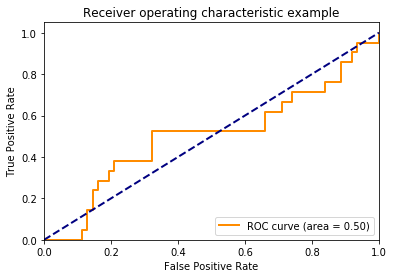

In [176]:
plotROC(fpr_SVM_DILI1, tpr_SVM_DILI1, roc_auc_score(B_test.iloc[:,0], y_sVM_DILI1[:,0]))

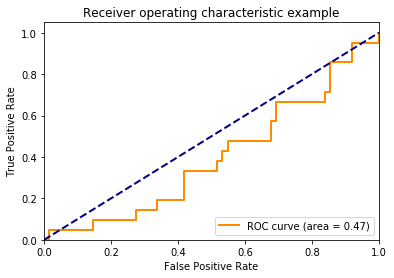

In [177]:
plotROC(fpr_SVM_DILI3, tpr_SVM_DILI3, roc_auc_score(B_test.iloc[:,1], y_sVM_DILI3[:,0]))

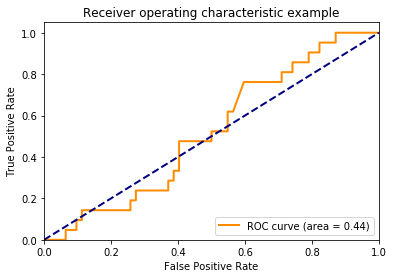

In [178]:
plotROC(fpr_SVM_DILI5, tpr_SVM_DILI5, roc_auc_score(B_test.iloc[:,2], y_sVM_DILI5[:,0]))

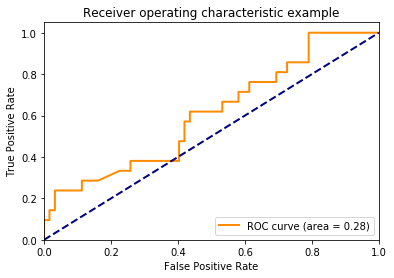

In [179]:
plotROC(fpr_SVM_DILI6, tpr_SVM_DILI6, roc_auc_score(B_test.iloc[:,3], y_sVM_DILI6[:,0]))

In [ ]:
cM(B_test.iloc[:,0], p_sVM_DILI1)

In [ ]:
cM(B_test.iloc[:,1], p_sVM_DILI3)

In [ ]:
cM(B_test.iloc[:,2], p_sVM_DILI5)

In [ ]:
cM(B_test.iloc[:,3], p_sVM_DILI6)

#### Multi-layer Perceptron

In [113]:
#Multi-layer Perceptron
def mlp(X_train, X_test, y_train) :
    MLP = MLPClassifier(hidden_layer_sizes=(50,50,50)) 

    ## Place the training data in the MLP to train your algorithm
    MLP.fit(X_train,y_train)

    ## This is where we test the trained algorithm
    predictions = MLP.predict(X_test)
    y_prob = MLP.predict_proba(X_test)

    return(predictions, y_prob)

In [114]:
p_mlp_DILI1, y_mlp_DILI1 = mlp(A_train, A_test, B_train['DILI1'])
p_mlp_DILI3, y_mlp_DILI3 = mlp(A_train, A_test, B_train['DILI3'])
p_mlp_DILI5, y_mlp_DILI5 = mlp(A_train, A_test, B_train['DILI5'])
p_mlp_DILI6, y_mlp_DILI6 = mlp(A_train, A_test, B_train['DILI6'])


In [115]:
#Calculate Accuracy
print('Multi-layer Perceptron (DILI1): ', round(accuracy_score(B_test.iloc[:,0], p_mlp_DILI1), 3))
print('Multi-layer Perceptron (DILI3): ', round(accuracy_score(B_test.iloc[:,1], p_mlp_DILI3), 3))
print('Multi-layer Perceptron (DILI5): ', round(accuracy_score(B_test.iloc[:,2], p_mlp_DILI5), 3))
print('Multi-layer Perceptron (DILI6): ', round(accuracy_score(B_test.iloc[:,3], p_mlp_DILI6), 3))

Multi-layer Perceptron (DILI1):  0.711
Multi-layer Perceptron (DILI3):  0.542
Multi-layer Perceptron (DILI5):  0.458
Multi-layer Perceptron (DILI6):  0.59


In [116]:
#Calculate Balanced Accuracy
print('Multi-layer Perceptron (DILI1): ', round(balanced_accuracy_score(B_test.iloc[:,0], p_mlp_DILI1), 3))
print('Multi-layer Perceptron (DILI3): ', round(balanced_accuracy_score(B_test.iloc[:,1], p_mlp_DILI3), 3))
print('Multi-layer Perceptron (DILI5): ', round(balanced_accuracy_score(B_test.iloc[:,2], p_mlp_DILI5), 3))
print('Multi-layer Perceptron (DILI6): ', round(balanced_accuracy_score(B_test.iloc[:,3], p_mlp_DILI6), 3))

Multi-layer Perceptron (DILI1):  0.492
Multi-layer Perceptron (DILI3):  0.504
Multi-layer Perceptron (DILI5):  0.457
Multi-layer Perceptron (DILI6):  0.594


In [117]:
#Calculate Precision Score
print('MLP Precision (DILI1): ', round(precision_score(B_test.iloc[:,0], p_mlp_DILI1), 3))
print('MLP Precision (DILI3): ', round(precision_score(B_test.iloc[:,1], p_mlp_DILI3), 3))
print('MLP Precision (DILI5): ', round(precision_score(B_test.iloc[:,2], p_mlp_DILI5), 3))
print('MLP Precision (DILI6): ', round(precision_score(B_test.iloc[:,3], p_mlp_DILI6), 3))


MLP Precision (DILI1):  0.2
MLP Precision (DILI3):  0.379
MLP Precision (DILI5):  0.436
MLP Precision (DILI6):  0.545


In [118]:
#Calculate ROC AUC Score
print('MLP ROC AUC Score (DILI1): ', round(roc_auc_score(B_test.iloc[:,0], y_mlp_DILI1[:,0]), 3))
print('MLP ROC AUC Score (DILI3): ', round(roc_auc_score(B_test.iloc[:,1], y_mlp_DILI3[:,0]), 3))
print('MLP ROC AUC Score (DILI5): ', round(roc_auc_score(B_test.iloc[:,2], y_mlp_DILI5[:,0]), 3))
print('MLP ROC AUC Score (DILI6): ', round(roc_auc_score(B_test.iloc[:,3], y_mlp_DILI6[:,0]), 3))


MLP ROC AUC Score (DILI1):  0.517
MLP ROC AUC Score (DILI3):  0.533
MLP ROC AUC Score (DILI5):  0.512
MLP ROC AUC Score (DILI6):  0.312


In [119]:
fpr_MLP_DILI1, tpr_MLP_DILI1, _ = roc_curve(B_test.iloc[:,0], y_mlp_DILI1[:,0])
fpr_MLP_DILI3, tpr_MLP_DILI3, _ = roc_curve(B_test.iloc[:,0], y_mlp_DILI3[:,0])
fpr_MLP_DILI5, tpr_MLP_DILI5, _ = roc_curve(B_test.iloc[:,0], y_mlp_DILI5[:,0])
fpr_MLP_DILI6, tpr_MLP_DILI6, _ = roc_curve(B_test.iloc[:,0], y_mlp_DILI6[:,0])
plotROC(fpr_MLP_DILI1, tpr_MLP_DILI1)

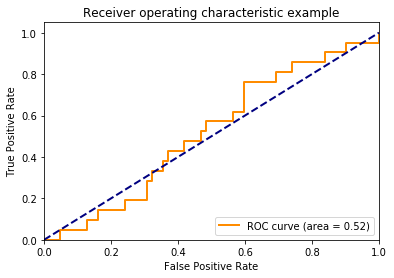

In [180]:
plotROC(fpr_MLP_DILI1, tpr_MLP_DILI1, roc_auc_score(B_test.iloc[:,0], y_mlp_DILI1[:,0]))

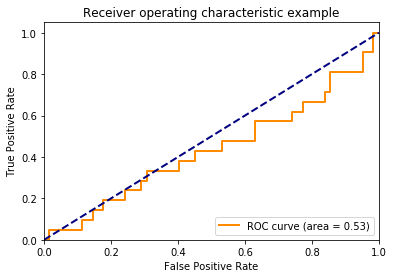

In [182]:
plotROC(fpr_MLP_DILI3, tpr_MLP_DILI3, roc_auc_score(B_test.iloc[:,1], y_mlp_DILI3[:,0]))

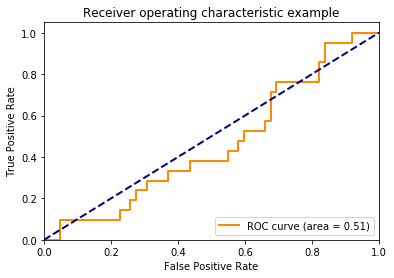

In [183]:
plotROC(fpr_MLP_DILI5, tpr_MLP_DILI5, roc_auc_score(B_test.iloc[:,2], y_mlp_DILI5[:,0]))

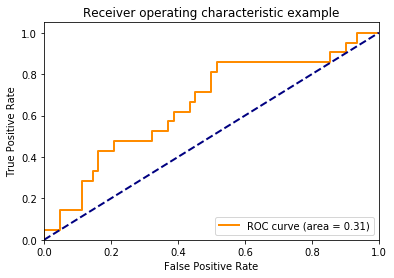

In [184]:
plotROC(fpr_MLP_DILI6, tpr_MLP_DILI6, roc_auc_score(B_test.iloc[:,3], y_mlp_DILI6[:,0]))

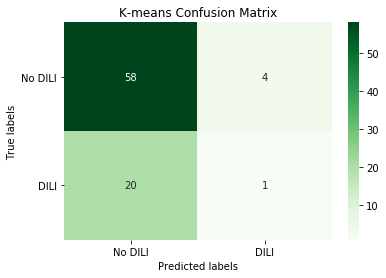

In [124]:
cM(B_test.iloc[:,0], p_mlp_DILI1)

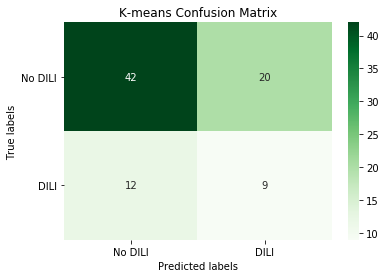

In [125]:
cM(B_test.iloc[:,0], p_mlp_DILI3)

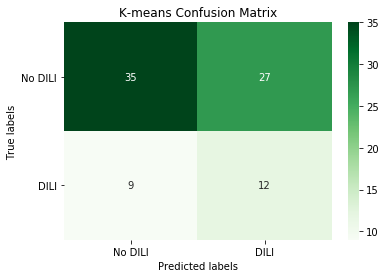

In [126]:
cM(B_test.iloc[:,0], p_mlp_DILI5)

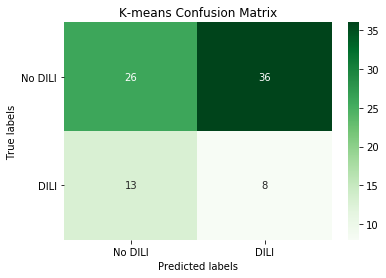

In [127]:
cM(B_test.iloc[:,0], p_mlp_DILI6)

#### Gradient Boosting with and without PCA

In [128]:
def xgb_PCA(X_train, X_test, y_train, PCA):
    xgb_model = xgb.XGBClassifier()

    if PCA == 1:
        X_train = pca3.fit_transform(X_train)
        X_test = pca3.fit_transform(X_test)
    
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)
    y_prob = xgb_model.predict_proba(X_test)
    
    return(xgb_pred, y_prob)

In [129]:
#Gradient Boost without PCA
p_xgb1_DILI1, y_xgb1_DILI1 = xgb_PCA(A_train, A_test, B_train['DILI1'], 0)
p_xgb1_DILI3, y_xgb1_DILI3 = xgb_PCA(A_train, A_test, B_train['DILI3'], 0)
p_xgb1_DILI5, y_xgb1_DILI5 = xgb_PCA(A_train, A_test, B_train['DILI5'], 0)
p_xgb1_DILI6, y_xgb1_DILI6 = xgb_PCA(A_train, A_test, B_train['DILI6'], 0)

In [130]:
#Calculate Accuracy
print('XGB (DILI1): ', round(accuracy_score(B_test.iloc[:,0], p_xgb1_DILI1), 3))
print('XGB (DILI3): ', round(accuracy_score(B_test.iloc[:,1], p_xgb1_DILI3), 3))
print('XGB (DILI5): ', round(accuracy_score(B_test.iloc[:,2], p_xgb1_DILI5), 3))
print('XGB (DILI6): ', round(accuracy_score(B_test.iloc[:,3], p_xgb1_DILI6), 3))


XGB (DILI1):  0.735
XGB (DILI3):  0.59
XGB (DILI5):  0.41
XGB (DILI6):  0.675


In [131]:
#Calculate Balanced Accuracy
print('XGB (DILI1): ', round(balanced_accuracy_score(B_test.iloc[:,0], p_xgb1_DILI1), 3))
print('XGB (DILI3): ', round(balanced_accuracy_score(B_test.iloc[:,1], p_xgb1_DILI3), 3))
print('XGB (DILI5): ', round(balanced_accuracy_score(B_test.iloc[:,2], p_xgb1_DILI5), 3))
print('XGB (DILI6): ', round(balanced_accuracy_score(B_test.iloc[:,3], p_xgb1_DILI6), 3))


XGB (DILI1):  0.492
XGB (DILI3):  0.51
XGB (DILI5):  0.408
XGB (DILI6):  0.686


In [132]:
#Calculate Precision Score
print('XGB Precision (DILI1): ', round(precision_score(B_test.iloc[:,0], p_xgb1_DILI1), 3))
print('XGB Precision (DILI3): ', round(precision_score(B_test.iloc[:,1], p_xgb1_DILI3), 3))
print('XGB Precision (DILI5): ', round(precision_score(B_test.iloc[:,2], p_xgb1_DILI5), 3))
print('XGB Precision (DILI6): ', round(precision_score(B_test.iloc[:,3], p_xgb1_DILI6), 3))


XGB Precision (DILI1):  0.0
XGB Precision (DILI3):  0.4
XGB Precision (DILI5):  0.378
XGB Precision (DILI6):  0.608


In [133]:
#Calculate ROC AUC Score
print('XGB ROC AUC Score (DILI1): ', round(roc_auc_score(B_test.iloc[:,0], y_xgb1_DILI1[:,0]), 3))
print('XGB ROC AUC Score (DILI3): ', round(roc_auc_score(B_test.iloc[:,1], y_xgb1_DILI3[:,0]), 3))
print('XGB ROC AUC Score (DILI5): ', round(roc_auc_score(B_test.iloc[:,2], y_xgb1_DILI5[:,0]), 3))
print('XGB ROC AUC Score (DILI6): ', round(roc_auc_score(B_test.iloc[:,3], y_xgb1_DILI6[:,0]), 3))


XGB ROC AUC Score (DILI1):  0.417
XGB ROC AUC Score (DILI3):  0.475
XGB ROC AUC Score (DILI5):  0.592
XGB ROC AUC Score (DILI6):  0.277


In [134]:
fpr_XGB1_DILI1, tpr_XGB1_DILI1, _ = roc_curve(B_test.iloc[:,0], y_xgb1_DILI1[:,0])
fpr_XGB1_DILI3, tpr_XGB1_DILI3, _ = roc_curve(B_test.iloc[:,0], y_xgb1_DILI3[:,0])
fpr_XGB1_DILI5, tpr_XGB1_DILI5, _ = roc_curve(B_test.iloc[:,0], y_xgb1_DILI5[:,0])
fpr_XGB1_DILI6, tpr_XGB1_DILI6, _ = roc_curve(B_test.iloc[:,0], y_xgb1_DILI6[:,0])


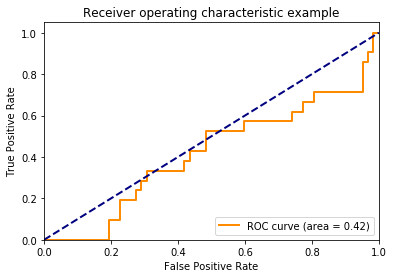

In [144]:
plotROC(fpr_XGB1_DILI1, tpr_XGB1_DILI1, roc_auc_score(B_test.iloc[:,0], y_xgb1_DILI1[:,0]))

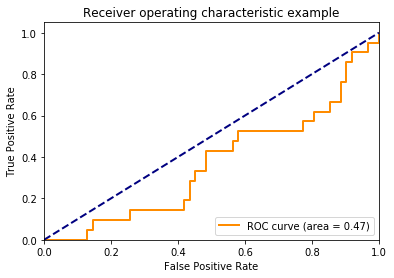

In [145]:
plotROC(fpr_XGB1_DILI3, tpr_XGB1_DILI3, roc_auc_score(B_test.iloc[:,1], y_xgb1_DILI3[:,0]))

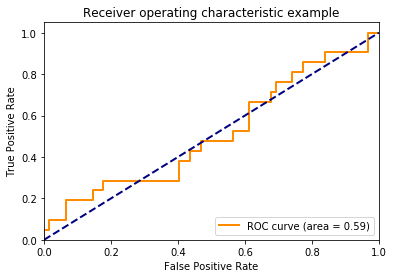

In [142]:
plotROC(fpr_XGB1_DILI5, tpr_XGB1_DILI5, roc_auc_score(B_test.iloc[:,2], y_xgb1_DILI5[:,0]))

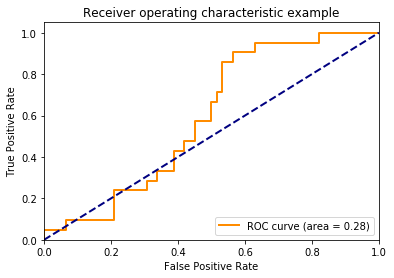

In [143]:
plotROC(fpr_XGB1_DILI6, tpr_XGB1_DILI6, roc_auc_score(B_test.iloc[:,3], y_xgb1_DILI6[:,0]))

In [ ]:
cM(B_test.iloc[:,0], p_xgb1_DILI1)

In [ ]:
cM(B_test.iloc[:,1], p_xgb1_DILI3)

In [ ]:
cM(B_test.iloc[:,2], p_xgb1_DILI5)

In [ ]:
cM(B_test.iloc[:,3], p_xgb1_DILI6)

In [146]:
p_xgb2_DILI1, y_xgb2_DILI1 = xgb_PCA(A_train, A_test, B_train['DILI1'], 1)
p_xgb2_DILI3, y_xgb2_DILI3 = xgb_PCA(A_train, A_test, B_train['DILI3'], 1)
p_xgb2_DILI5, y_xgb2_DILI5 = xgb_PCA(A_train, A_test, B_train['DILI5'], 1)
p_xgb2_DILI6, y_xgb2_DILI6 = xgb_PCA(A_train, A_test, B_train['DILI6'], 1)

In [147]:
#Calculate Accuracy
print('XGB with PCA (DILI1): ', round(accuracy_score(B_test.iloc[:,0], p_xgb2_DILI1), 3))
print('XGB with PCA (DILI3): ', round(accuracy_score(B_test.iloc[:,1], p_xgb2_DILI3), 3))
print('XGB with PCA (DILI5): ', round(accuracy_score(B_test.iloc[:,2], p_xgb2_DILI5), 3))
print('XGB with PCA (DILI6): ', round(accuracy_score(B_test.iloc[:,3], p_xgb2_DILI6), 3))


XGB with PCA (DILI1):  0.759
XGB with PCA (DILI3):  0.518
XGB with PCA (DILI5):  0.494
XGB with PCA (DILI6):  0.506


In [148]:
#Calculate Balanced Accuracy
print('XGB with PCA (DILI1): ', round(balanced_accuracy_score(B_test.iloc[:,0], p_xgb2_DILI1), 3))
print('XGB with PCA (DILI3): ', round(balanced_accuracy_score(B_test.iloc[:,1], p_xgb2_DILI3), 3))
print('XGB with PCA (DILI5): ', round(balanced_accuracy_score(B_test.iloc[:,2], p_xgb2_DILI5), 3))
print('XGB with PCA (DILI6): ', round(balanced_accuracy_score(B_test.iloc[:,3], p_xgb2_DILI6), 3))


XGB with PCA (DILI1):  0.555
XGB with PCA (DILI3):  0.472
XGB with PCA (DILI5):  0.491
XGB with PCA (DILI6):  0.508


In [149]:
#Calculate Precision Score
print('XGB (PCA) Precision (DILI1): ', round(precision_score(B_test.iloc[:,0], p_xgb2_DILI1), 3))
print('XGB (PCA) Precision (DILI3): ', round(precision_score(B_test.iloc[:,1], p_xgb2_DILI3), 3))
print('XGB (PCA) Precision (DILI5): ', round(precision_score(B_test.iloc[:,2], p_xgb2_DILI5), 3))
print('XGB (PCA) Precision (DILI6): ', round(precision_score(B_test.iloc[:,3], p_xgb2_DILI6), 3))


XGB (PCA) Precision (DILI1):  0.6
XGB (PCA) Precision (DILI3):  0.333
XGB (PCA) Precision (DILI5):  0.471
XGB (PCA) Precision (DILI6):  0.465


In [150]:
#Calculate ROC AUC Score
print('XGB (PCA) ROC AUC Score (DILI1): ', round(roc_auc_score(B_test.iloc[:,0], y_xgb2_DILI1[:,0]), 3))
print('XGB (PCA) ROC AUC Score (DILI3): ', round(roc_auc_score(B_test.iloc[:,1], y_xgb2_DILI3[:,0]), 3))
print('XGB (PCA) ROC AUC Score (DILI5): ', round(roc_auc_score(B_test.iloc[:,2], y_xgb2_DILI5[:,0]), 3))
print('XGB (PCA) ROC AUC Score (DILI6): ', round(roc_auc_score(B_test.iloc[:,3], y_xgb2_DILI6[:,0]), 3))


XGB (PCA) ROC AUC Score (DILI1):  0.327
XGB (PCA) ROC AUC Score (DILI3):  0.516
XGB (PCA) ROC AUC Score (DILI5):  0.479
XGB (PCA) ROC AUC Score (DILI6):  0.48


In [151]:
fpr_XGB2_DILI1, tpr_XGB2_DILI1, _ = roc_curve(B_test.iloc[:,0], y_xgb2_DILI1[:,0])
fpr_XGB2_DILI3, tpr_XGB2_DILI3, _ = roc_curve(B_test.iloc[:,0], y_xgb2_DILI3[:,0])
fpr_XGB2_DILI5, tpr_XGB2_DILI5, _ = roc_curve(B_test.iloc[:,0], y_xgb2_DILI5[:,0])
fpr_XGB2_DILI6, tpr_XGB2_DILI6, _ = roc_curve(B_test.iloc[:,0], y_xgb2_DILI6[:,0])


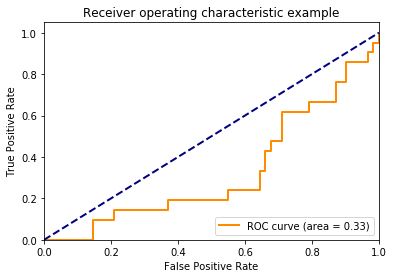

In [152]:
plotROC(fpr_XGB2_DILI1, tpr_XGB2_DILI1, roc_auc_score(B_test.iloc[:,0], y_xgb2_DILI1[:,0]))

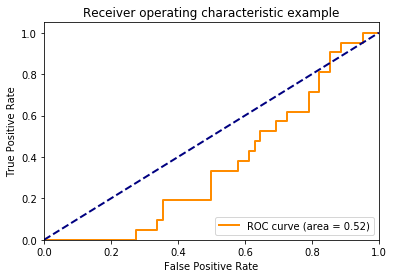

In [153]:
plotROC(fpr_XGB2_DILI3, tpr_XGB2_DILI3, roc_auc_score(B_test.iloc[:,1], y_xgb2_DILI3[:,0]))

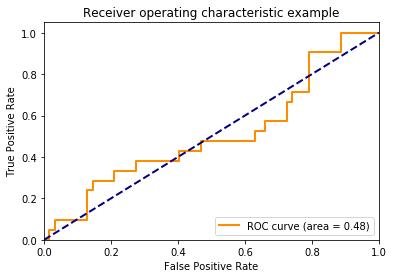

In [154]:
plotROC(fpr_XGB2_DILI5, tpr_XGB2_DILI5, roc_auc_score(B_test.iloc[:,2], y_xgb2_DILI5[:,0]))

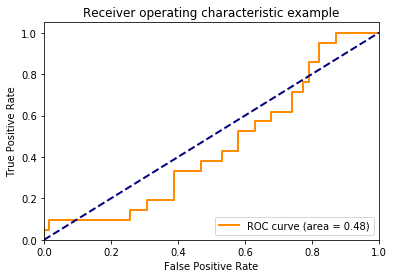

In [155]:
plotROC(fpr_XGB2_DILI6, tpr_XGB2_DILI6, roc_auc_score(B_test.iloc[:,3], y_xgb2_DILI6[:,0]))

In [ ]:
cM(B_test.iloc[:,0], p_xgb2_DILI1)

In [ ]:
cM(B_test.iloc[:,1], p_xgb2_DILI3)

In [ ]:
cM(B_test.iloc[:,2], p_xgb2_DILI5)

In [ ]:
cM(B_test.iloc[:,3], p_xgb2_DILI6)

#### Ensemble Classification

In [185]:
def ensemble(X_train, X_test, y_train):
    A1 = linear_model.LogisticRegression()
    A2 = svm.SVC(probability=True)
    A3 = GaussianNB()
    A4 = KNeighborsClassifier(n_neighbors=5) 
    A5 = MLPClassifier(hidden_layer_sizes=(30,30,30))
    A6 = xgb.XGBClassifier()
        
    estimators = []

    estimators.append(('logistic', A1))
    estimators.append(('svm', A2))
    estimators.append(('Gussian', A3))
    estimators.append(('KNeighbors', A4))
    estimators.append(('MLP', A5))
    estimators.append(('XGB', A6))

    ensemble = VotingClassifier(estimators, voting='soft')
    
    ensemble.fit(X_train, y_train)

    predictions = ensemble.predict(X_test)
    y_prob = ensemble.predict_proba(X_test)

    return(predictions, y_prob)

In [187]:
p_ens_DILI1, y_ens_DILI1 = ensemble(A_train, A_test, B_train['DILI1'])
p_ens_DILI3, y_ens_DILI3 = ensemble(A_train, A_test, B_train['DILI3'])
p_ens_DILI5, y_ens_DILI5 = ensemble(A_train, A_test, B_train['DILI5'])
p_ens_DILI6, y_ens_DILI6 = ensemble(A_train, A_test, B_train['DILI6'])


/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitl

In [188]:
#Calculate Accuracy
print('Ensemble (DILI1): ', round(accuracy_score(B_test.iloc[:,0], p_ens_DILI1), 3))
print('Ensemble (DILI3): ', round(accuracy_score(B_test.iloc[:,1], p_ens_DILI3), 3))
print('Ensemble (DILI5): ', round(accuracy_score(B_test.iloc[:,2], p_ens_DILI5), 3))
print('Ensemble (DILI6): ', round(accuracy_score(B_test.iloc[:,3], p_ens_DILI6), 3))

Ensemble (DILI1):  0.735
Ensemble (DILI3):  0.566
Ensemble (DILI5):  0.398
Ensemble (DILI6):  0.675


In [189]:
#Calculate Balanced Accuracy
print('Ensemble (DILI1): ', round(balanced_accuracy_score(B_test.iloc[:,0], p_ens_DILI1), 3))
print('Ensemble (DILI3): ', round(balanced_accuracy_score(B_test.iloc[:,1], p_ens_DILI3), 3))
print('Ensemble (DILI5): ', round(balanced_accuracy_score(B_test.iloc[:,2], p_ens_DILI5), 3))
print('Ensemble (DILI6): ', round(balanced_accuracy_score(B_test.iloc[:,3], p_ens_DILI6), 3))


Ensemble (DILI1):  0.492
Ensemble (DILI3):  0.504
Ensemble (DILI5):  0.395
Ensemble (DILI6):  0.671


In [190]:
#Calculate Precision Score
print('Ensemble (DILI1): ', round(precision_score(B_test.iloc[:,0], p_ens_DILI1), 3))
print('Ensemble (DILI3): ', round(precision_score(B_test.iloc[:,1], p_ens_DILI3), 3))
print('Ensemble (DILI5): ', round(precision_score(B_test.iloc[:,2], p_ens_DILI5), 3))
print('Ensemble (DILI6): ', round(precision_score(B_test.iloc[:,3], p_ens_DILI6), 3))


Ensemble (DILI1):  0.0
Ensemble (DILI3):  0.381
Ensemble (DILI5):  0.361
Ensemble (DILI6):  0.649


In [191]:
#Calculate ROC AUC Score
print('Ensemble ROC AUC Score (DILI1): ', round(roc_auc_score(B_test.iloc[:,0], y_ens_DILI1[:,0]), 3))
print('Ensemble ROC AUC Score (DILI3): ', round(roc_auc_score(B_test.iloc[:,1], y_ens_DILI3[:,0]), 3))
print('Ensemble ROC AUC Score (DILI5): ', round(roc_auc_score(B_test.iloc[:,2], y_ens_DILI5[:,0]), 3))
print('Ensemble ROC AUC Score (DILI6): ', round(roc_auc_score(B_test.iloc[:,3], y_ens_DILI6[:,0]), 3))


Ensemble ROC AUC Score (DILI1):  0.425
Ensemble ROC AUC Score (DILI3):  0.498
Ensemble ROC AUC Score (DILI5):  0.612
Ensemble ROC AUC Score (DILI6):  0.28


In [192]:
#Calculate ROC AUC Score
fpr_ens_DILI1, tpr_ens_DILI1, _ = roc_curve(B_test.iloc[:,0], y_ens_DILI1[:,0])
fpr_ens_DILI3, tpr_ens_DILI3, _ = roc_curve(B_test.iloc[:,0], y_ens_DILI3[:,0])
fpr_ens_DILI5, tpr_ens_DILI5, _ = roc_curve(B_test.iloc[:,0], y_ens_DILI5[:,0])
fpr_ens_DILI6, tpr_ens_DILI6, _ = roc_curve(B_test.iloc[:,0], y_ens_DILI6[:,0])

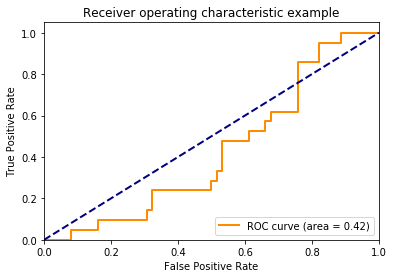

In [193]:
plotROC(fpr_ens_DILI1, tpr_ens_DILI1, roc_auc_score(B_test.iloc[:,0], y_ens_DILI1[:,0]))

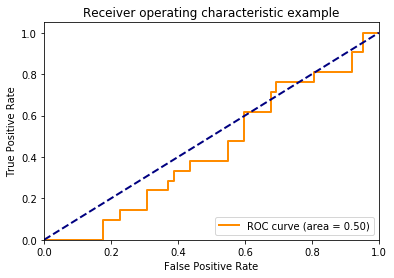

In [194]:
plotROC(fpr_ens_DILI3, tpr_ens_DILI3, roc_auc_score(B_test.iloc[:,1], y_ens_DILI3[:,0]))

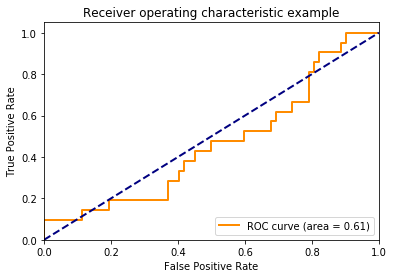

In [195]:
plotROC(fpr_ens_DILI5, tpr_ens_DILI5, roc_auc_score(B_test.iloc[:,2], y_ens_DILI5[:,0]))

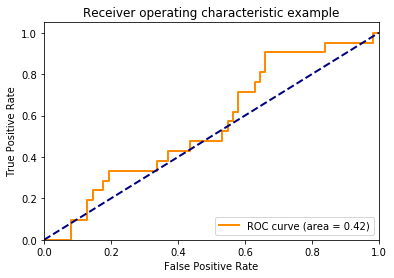

In [196]:
plotROC(fpr_ens_DILI6, tpr_ens_DILI6, roc_auc_score(B_test.iloc[:,3], y_ens_DILI5[:,0]))

## Comparing Methods and Testing on classifying unknown drugs

DataFrames Final_Train and Final_Test will now be used. We will classify whether drugs cause DILI using method that is the 'best'